# Modelling!

I will now dive into modelling the WNV cases using the datasets created in the previous Preprocessing notebook.  Hopefully I can improve upon the Logistic Regression model (especially the recall score) at the end of that notebook. 

Steps:
1.  Import data sets and modeling packages from sklearn. 
2. Try different models, tune hyperparameters and evaluate each.  
    1. Random Forest
    2. Gradient Boost
    3. XG Boost
    4. Support Vector Classifier
    5. Revist Logistic regression
3. Select the best model and output the model. Selection will be based on:
    - Test AUC score
    - Test Recall score

Import pandas numpy and all of the datasets.

In [1]:
random_seed = 27

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
y_train = pd.read_csv('y_train.csv',index_col=0).to_numpy().reshape(-1,)
y_test = pd.read_csv('y_test.csv',index_col=0).to_numpy().reshape(-1,)

### Note these are already standard scaled
X_train = pd.read_csv('X_train.csv',index_col=0).to_numpy()
X_test = pd.read_csv('X_test.csv',index_col=0).to_numpy()

#X_train_pca95 = pd.read_csv('X_train_pca95.csv',index_col=0).to_numpy()
#X_test_pca95 = pd.read_csv('X_test_pca95.csv',index_col=0).to_numpy()

#X_train_nmf = pd.read_csv('X_train_nmf.csv',index_col=0).to_numpy()
#X_test_nmf = pd.read_csv('X_test_nmf.csv',index_col=0).to_numpy()

Next a couple functions that will help in evaluating model performance and collecting the model metrics to help with selecting a model.

In [4]:
def Model_Eval(estimator,X_train,X_test,y_train,y_test):
    from sklearn.metrics import plot_confusion_matrix,precision_score,\
                                recall_score, plot_roc_curve
    import matplotlib.pyplot as plt
    
    fig,ax = plt.subplots(figsize=(5,5))
    plot_roc_curve(estimator,X_train,y_train,ax=ax,name='Train')
    plot_roc_curve(estimator,X_test,y_test,ax=ax,name='Test')
    plt.title('ROC curve')
    plt.show()

    fig,ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
    plot_confusion_matrix(estimator,X_train,y_train,values_format='.4g',ax=ax[0],cmap='Blues')
    plot_confusion_matrix(estimator,X_test,y_test,values_format='.4g',ax=ax[1],cmap='Oranges')
    ax[0].set_title('Train')
    ax[1].set_title('Test')
    plt.show()

    ### Training
    print('Train Precision {:.3f}'.format(precision_score(\
                              y_train,estimator.predict(X_train))))
    print('Train Recall    {:.3f}'.format(recall_score(\
                               y_train,estimator.predict(X_train))))
    print()
    ### Testing
    print('Test Precision  {:.3f}'.format(precision_score(\
                              y_test,estimator.predict(X_test))))
    print('Test Recall     {:.3f}'.format(recall_score(\
                               y_test,estimator.predict(X_test))))

Initialize dataframe for collecting model performance

In [5]:
df_cols = ['Model','Train_AUC','Test_AUC','Train_prec','Train_recal','Test_prec','Test_recal']
scores_df=pd.DataFrame(columns=df_cols)

Define function that will update the model performance dataframe

In [6]:
def agg_score_df(scores_df,estimator,name,X_train,X_test,y_train,y_test,\
                 df_cols=['Model','Train_AUC','Test_AUC','Train_prec',\
                          'Train_recal','Test_prec','Test_recal']):
    """
    """
    scores=[]
    scores.append(name)
    scores.append(roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1]))
    scores.append(roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1]))
    scores.append(precision_score(y_train,estimator.predict(X_train)))
    scores.append(recall_score(y_train,estimator.predict(X_train)))
    scores.append(precision_score(y_test,estimator.predict(X_test)))
    scores.append(recall_score(y_test,estimator.predict(X_test)))
    
    scores = np.array(scores).reshape(1,7)
    scores_df = pd.concat([scores_df,pd.DataFrame(scores,columns=df_cols)])

    return scores_df.reset_index(drop=True)

Ready for modelling! First I will try a RandomForest classifier

# Random Forest Classifier

In [7]:
### import necessities from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, plot_confusion_matrix,\
                plot_precision_recall_curve, plot_roc_curve, make_scorer,\
                recall_score, precision_score, log_loss

In [8]:
### Default Random Forest

rf_clf = RandomForestClassifier(random_state=random_seed)
rf_clf.fit(X_train,y_train)
print('Train AUC: {:.3f}'.format(roc_auc_score(y_train,rf_clf.predict_proba(X_train)[:,1])))
print('Test AUC: {:.3f}'.format(roc_auc_score(y_test,rf_clf.predict_proba(X_test)[:,1])))

Train AUC: 0.884
Test AUC: 0.823


That looks ok.  It seems it is not overfit and it has pretty good predictive power with better performance than the default logistic regression.  
___
Next I will use GridSearchCV to perform a cross validation and tune the hyperparameters of the classifier. 

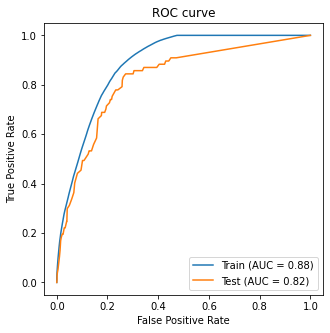

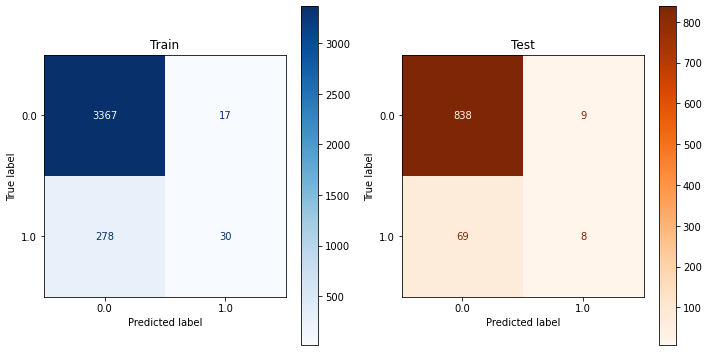

Train Precision 0.638
Train Recall    0.097

Test Precision  0.471
Test Recall     0.104


In [9]:
Model_Eval(rf_clf,X_train,X_test,y_train,y_test)

The precision and recall scores don't look great.  For this project I need higher recall, because I don't want to miss a lot of positive WNV cases.  Here I will start aggregating the scores to in a dataframe to make it easier to decide which is the best model.  

In [10]:
scores_df = agg_score_df(scores_df,rf_clf,'RandomForest default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8841175815909859,0.8233950229227679,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039


In [11]:
for i in RandomForestClassifier().get_params().keys():print(i)

bootstrap
ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
max_samples
min_impurity_decrease
min_impurity_split
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [12]:
### define grid parameters and fit model

params={'n_estimators':[50,80,100,120,150],\
       'criterion': ['gini','entropy'],\
       'max_depth':[3,5,7,9],
       'class_weight':['balanced'],\
       'random_state': [random_seed]}

rf_clf = RandomForestClassifier()

grid_rf_clf = GridSearchCV(rf_clf,param_grid=params,cv=5,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score))

grid_rf_clf.fit(X_train,y_train)

print('Best Params: ',grid_rf_clf.best_params_)
print('Best Score: ',grid_rf_clf.best_score_)

Best Params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 150, 'random_state': 27}
Best Score:  0.7714504241392952


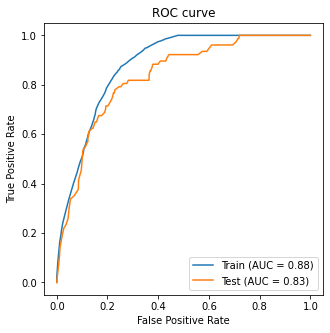

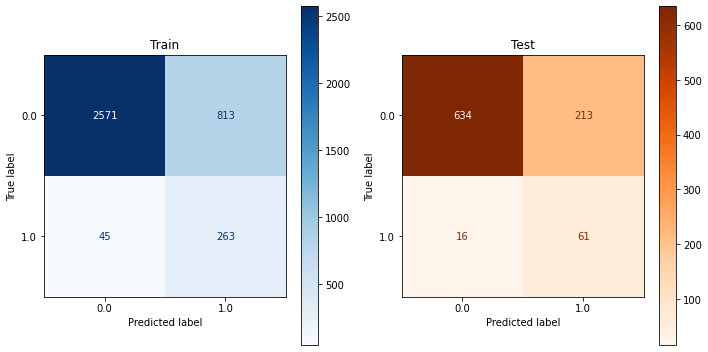

Train Precision 0.244
Train Recall    0.854

Test Precision  0.223
Test Recall     0.792


In [13]:
Model_Eval(grid_rf_clf,X_train,X_test,y_train,y_test)

That looks better but I am a little concerned about the difference in the training and testing AUC's.  The model might be a little overfit.  Maybe I should try to decrease the `max_depth` of the individual trees.  Recall has increased dramatically over the logistic regression model and the default RF.  Lets look at the precision-recall plot.

Lets look at the precision-recall plot.

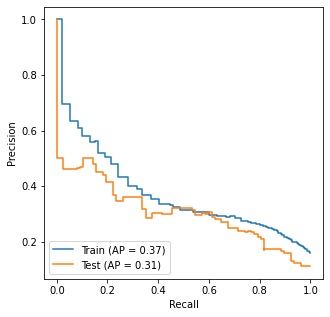

In [14]:
fig,ax = plt.subplots(figsize=(5,5))
plot_precision_recall_curve(grid_rf_clf,X_train,y_train,ax=ax,name='Train')
plot_precision_recall_curve(grid_rf_clf,X_test,y_test,ax=ax,name='Test')
plt.show()


This is not ideal.  This plot again shows the difference in performance in the training and testing set. Now I will try the same exercise above but using the PCA reduced features.  

In [15]:
scores_df = agg_score_df(scores_df,grid_rf_clf,'RandomForest tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8841175815909859,0.8233950229227679,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039
1,RandomForest tuned,0.8791620613429124,0.8330241187384044,0.24442379182156135,0.8538961038961039,0.22262773722627738,0.7922077922077922


The tuned model is much better, but may still be a little to overfitted to the training data.
___
To mitigate overfitting I will try using the PCA transformed features. 

The PCA dataset contains the top 15 PCA components, that explain 95% of the variance in the dataset.  The PCA trained random forest has a slightly lower AUC score but a higher test recall, which suggests it is less biased than the previous model trained on the full dataset.  

# Boosted Decision trees

In [16]:
### Import gradient boost and xgboost
from sklearn.ensemble import GradientBoostingClassifier



First I will try the Gradient Boosting classifier from sklearn, starting with the default model. 

In [17]:

params={'learning_rate':[0.1]}

gb_clf = GradientBoostingClassifier(random_state=random_seed)
grid_gb_clf = GridSearchCV(gb_clf,param_grid=params,cv=5,\
                           scoring = make_scorer(roc_auc_score))
grid_gb_clf.fit(X_train,y_train)

print('Train AUC: ', roc_auc_score(y_train,grid_gb_clf.predict_proba(X_train)[:,1]))
print('Test AUC: ', roc_auc_score(y_test,grid_gb_clf.predict_proba(X_test)[:,1]))



Train AUC:  0.8775741840901417
Test AUC:  0.8401846087796501


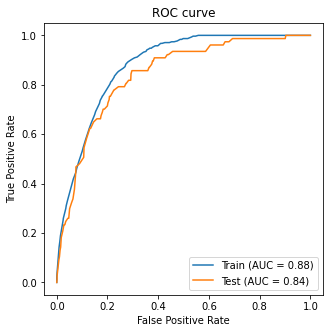

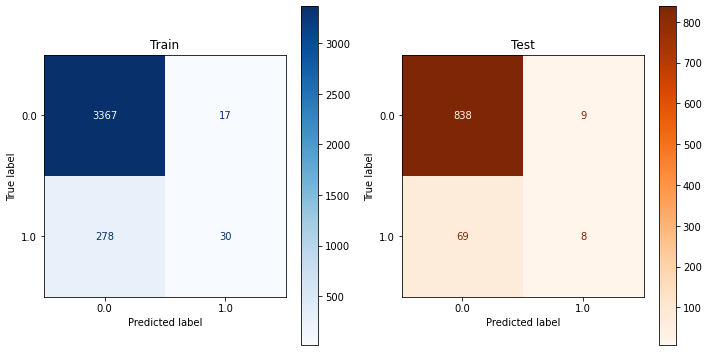

Train Precision 0.638
Train Recall    0.097

Test Precision  0.471
Test Recall     0.104


In [18]:
Model_Eval(grid_gb_clf,X_train,X_test,y_train,y_test)

In [19]:
scores_df = agg_score_df(scores_df,grid_gb_clf,'Gradient Boost default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8841175815909859,0.8233950229227679,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039
1,RandomForest tuned,0.8791620613429124,0.8330241187384044,0.24442379182156135,0.8538961038961039,0.22262773722627738,0.7922077922077922
2,Gradient Boost default,0.8775741840901417,0.8401846087796501,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039


The AUC's look great, but the recall is very low.  The model needs to do have a better recall score so it doesn't miss a lot of positive WNV cases.  Now I will try to tune the model.     

In [20]:
### Gradient Boosting Classifier parameters
for i in GradientBoostingClassifier().get_params().keys():print(i)

ccp_alpha
criterion
init
learning_rate
loss
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_impurity_split
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_iter_no_change
presort
random_state
subsample
tol
validation_fraction
verbose
warm_start


In [21]:
### Gradient boosting model
params = {'max_depth':[2,3,5,7,9],\
         'learning_rate':[.01,0.1,0.5,1],\
         'n_estimators':[20,50,100,150]}


gb_clf = GradientBoostingClassifier(random_state=random_seed,\
                                   n_iter_no_change=3)

grid_gb_clf = GridSearchCV(gb_clf,param_grid=params,cv=5,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score))

grid_gb_clf.fit(X_train,y_train)

print('Best Params: ',grid_gb_clf.best_params_)
print('Best Score: ',grid_gb_clf.best_score_)


Best Params:  {'learning_rate': 1, 'max_depth': 9, 'n_estimators': 20}
Best Score:  0.5515849410780616


That took much longer than the random forest, the ensemble is done in series after all.  

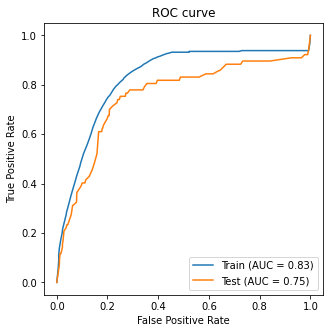

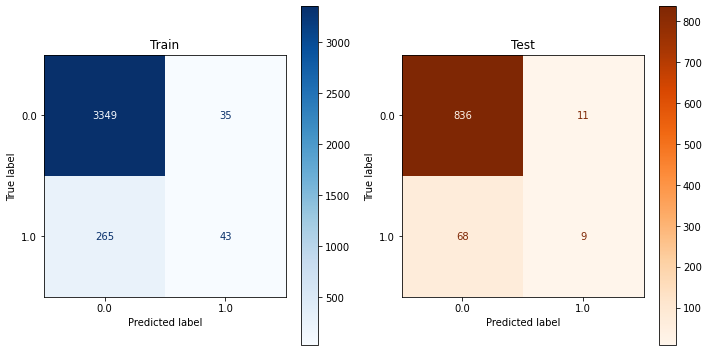

Train Precision 0.551
Train Recall    0.140

Test Precision  0.450
Test Recall     0.117


In [22]:
Model_Eval(grid_gb_clf,X_train,X_test,y_train,y_test)

In [23]:
scores_df = agg_score_df(scores_df,grid_gb_clf,'Gradient Boost tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8841175815909859,0.8233950229227679,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039
1,RandomForest tuned,0.8791620613429124,0.8330241187384044,0.24442379182156135,0.8538961038961039,0.22262773722627738,0.7922077922077922
2,Gradient Boost default,0.8775741840901417,0.8401846087796501,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039
3,Gradient Boost tuned,0.8255157962604772,0.7522731105966054,0.5512820512820513,0.1396103896103896,0.45,0.11688311688311688


The AUC's are now both lower than the default model??.  The tuned model also has lower precision and recall than the default??? Why tune?


The tuned Gradient Boosting model scores lower than the tuned Random Forest model.  


Now I will prefrom the same modeling task but using the PCA transformed features. 

Using the PCA transformed dataset produced an even more biased and overfit model.

## XG Boost

Now I will try a default XG Boost model and then attempt to improve it by tuning the hyper parameters.

In [24]:
import xgboost

In [25]:
eval_set=[(X_train,y_train),(X_test,y_test)]
eval_metric = ['error','aucpr','auc']


model = xgboost.XGBClassifier(n_estimators=100,\
                              random_state=random_seed)

model.fit(X_train,y_train,eval_metric=eval_metric, \
          eval_set=eval_set,verbose=True)

print()
print('Test AUC score: ',roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
print('Test recall: ',recall_score(y_test,model.predict(X_test)))

[0]	validation_0-error:0.08180	validation_0-aucpr:0.34040	validation_0-auc:0.81396	validation_1-error:0.08333	validation_1-aucpr:0.26895	validation_1-auc:0.78323
[1]	validation_0-error:0.08099	validation_0-aucpr:0.36183	validation_0-auc:0.84064	validation_1-error:0.08550	validation_1-aucpr:0.28438	validation_1-auc:0.82267
[2]	validation_0-error:0.08099	validation_0-aucpr:0.37218	validation_0-auc:0.85472	validation_1-error:0.08550	validation_1-aucpr:0.29990	validation_1-auc:0.83941
[3]	validation_0-error:0.08099	validation_0-aucpr:0.37757	validation_0-auc:0.85675	validation_1-error:0.08550	validation_1-aucpr:0.30647	validation_1-auc:0.84278
[4]	validation_0-error:0.08017	validation_0-aucpr:0.38193	validation_0-auc:0.86270	validation_1-error:0.08550	validation_1-aucpr:0.30316	validation_1-auc:0.84162
[5]	validation_0-error:0.08017	validation_0-aucpr:0.38648	validation_0-auc:0.87432	validation_1-error:0.08550	validation_1-aucpr:0.30048	validation_1-auc:0.84130
[6]	validation_0-error:0.080

C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-error:0.08017	validation_0-aucpr:0.39282	validation_0-auc:0.88321	validation_1-error:0.08550	validation_1-aucpr:0.30118	validation_1-auc:0.83778
[19]	validation_0-error:0.08017	validation_0-aucpr:0.39286	validation_0-auc:0.88324	validation_1-error:0.08550	validation_1-aucpr:0.30098	validation_1-auc:0.83724
[20]	validation_0-error:0.08017	validation_0-aucpr:0.39283	validation_0-auc:0.88317	validation_1-error:0.08550	validation_1-aucpr:0.30101	validation_1-auc:0.83738
[21]	validation_0-error:0.08017	validation_0-aucpr:0.39320	validation_0-auc:0.88329	validation_1-error:0.08550	validation_1-aucpr:0.30178	validation_1-auc:0.83779
[22]	validation_0-error:0.08017	validation_0-aucpr:0.39326	validation_0-auc:0.88339	validation_1-error:0.08550	validation_1-aucpr:0.30180	validation_1-auc:0.83775
[23]	validation_0-error:0.08017	validation_0-aucpr:0.39325	validation_0-auc:0.88338	validation_1-error:0.08550	validation_1-aucpr:0.30219	validation_1-auc:0.83710
[24]	validation_0-erro

[69]	validation_0-error:0.07990	validation_0-aucpr:0.39927	validation_0-auc:0.88430	validation_1-error:0.08442	validation_1-aucpr:0.31454	validation_1-auc:0.83718
[70]	validation_0-error:0.07990	validation_0-aucpr:0.39927	validation_0-auc:0.88431	validation_1-error:0.08442	validation_1-aucpr:0.31450	validation_1-auc:0.83701
[71]	validation_0-error:0.07990	validation_0-aucpr:0.39926	validation_0-auc:0.88430	validation_1-error:0.08442	validation_1-aucpr:0.31464	validation_1-auc:0.83718
[72]	validation_0-error:0.07990	validation_0-aucpr:0.39927	validation_0-auc:0.88430	validation_1-error:0.08442	validation_1-aucpr:0.31450	validation_1-auc:0.83684
[73]	validation_0-error:0.07990	validation_0-aucpr:0.39926	validation_0-auc:0.88430	validation_1-error:0.08442	validation_1-aucpr:0.31447	validation_1-auc:0.83669
[74]	validation_0-error:0.07990	validation_0-aucpr:0.39926	validation_0-auc:0.88430	validation_1-error:0.08442	validation_1-aucpr:0.31449	validation_1-auc:0.83675
[75]	validation_0-erro

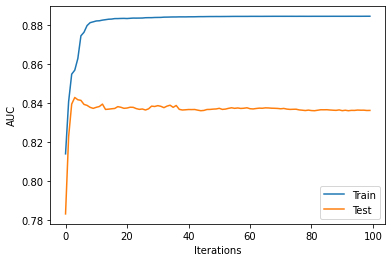

In [26]:
plt.plot(np.arange(len(model.evals_result_['validation_0']['auc'])),\
        model.evals_result_['validation_0']['auc'])
plt.plot(np.arange(len(model.evals_result_['validation_1']['auc'])),\
        model.evals_result_['validation_1']['auc'])

plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.legend(labels=['Train','Test'])


plt.show()



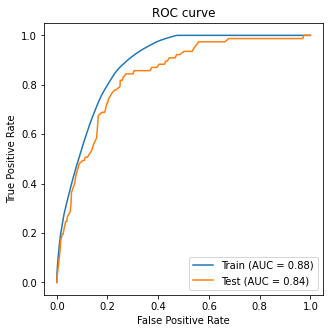

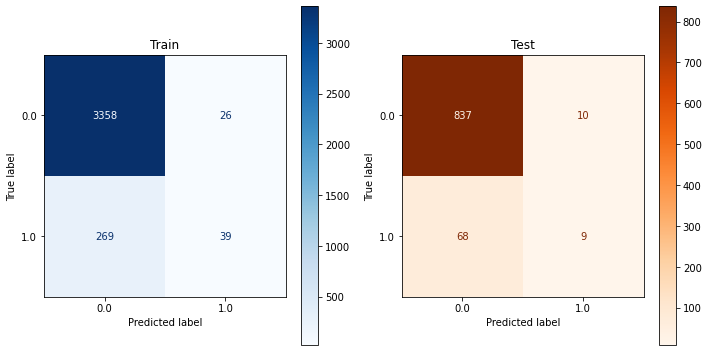

Train Precision 0.600
Train Recall    0.127

Test Precision  0.474
Test Recall     0.117


In [27]:
Model_Eval(model,X_train,X_test,y_train,y_test)

The default XGBoost model only needed a few iterations to optimize.  Beyond that it is clearly overfitting to the training set.  This model's recall is too low.  Now I will re-do this model with a stopping criteria. 


In [28]:
scores_df = agg_score_df(scores_df,model,'XG Boost default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8841175815909859,0.8233950229227679,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039
1,RandomForest tuned,0.8791620613429124,0.8330241187384044,0.24442379182156135,0.8538961038961039,0.22262773722627738,0.7922077922077922
2,Gradient Boost default,0.8775741840901417,0.8401846087796501,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039
3,Gradient Boost tuned,0.8255157962604772,0.7522731105966054,0.5512820512820513,0.1396103896103896,0.45,0.11688311688311688
4,XG Boost default,0.8843363344693133,0.8361673745380948,0.6,0.1266233766233766,0.47368421052631576,0.11688311688311688


In [29]:
eval_set=[(X_train,y_train),(X_test,y_test)]
eval_metric = ['error','aucpr','auc']


model = xgboost.XGBClassifier(n_estimators=100,\
                             random_state=random_seed)

model.fit(X_train,y_train,eval_metric=eval_metric, \
          early_stopping_rounds=2,eval_set=eval_set,verbose=True)

print()
print('Test AUC score: ',roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
print('Test recall: ',recall_score(y_test,model.predict(X_test)))

[0]	validation_0-error:0.08180	validation_0-aucpr:0.34040	validation_0-auc:0.81396	validation_1-error:0.08333	validation_1-aucpr:0.26895	validation_1-auc:0.78323
[1]	validation_0-error:0.08099	validation_0-aucpr:0.36183	validation_0-auc:0.84064	validation_1-error:0.08550	validation_1-aucpr:0.28438	validation_1-auc:0.82267
[2]	validation_0-error:0.08099	validation_0-aucpr:0.37218	validation_0-auc:0.85472	validation_1-error:0.08550	validation_1-aucpr:0.29990	validation_1-auc:0.83941
[3]	validation_0-error:0.08099	validation_0-aucpr:0.37757	validation_0-auc:0.85675	validation_1-error:0.08550	validation_1-aucpr:0.30647	validation_1-auc:0.84278
[4]	validation_0-error:0.08017	validation_0-aucpr:0.38193	validation_0-auc:0.86270	validation_1-error:0.08550	validation_1-aucpr:0.30316	validation_1-auc:0.84162
[5]	validation_0-error:0.08017	validation_0-aucpr:0.38648	validation_0-auc:0.87432	validation_1-error:0.08550	validation_1-aucpr:0.30048	validation_1-auc:0.84130

Test AUC score:  0.84278354

C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


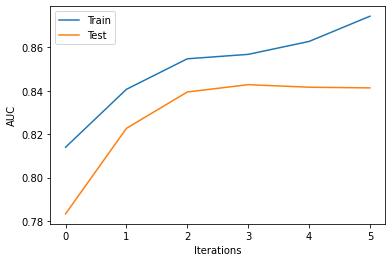

In [30]:
plt.plot(np.arange(len(model.evals_result_['validation_0']['auc'])),\
        model.evals_result_['validation_0']['auc'])
plt.plot(np.arange(len(model.evals_result_['validation_1']['auc'])),\
        model.evals_result_['validation_1']['auc'])

plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.legend(labels=['Train','Test'])


plt.show()



Adding the early stopping limitation of 2 iterations results in the model only completing 5 iterations.  The model appears to not be overfit now.  But the recall is way too low for the purpose of the model.  To increase recall, I will add a weighting scheme where the positive cases have a significantly higher weight than the negative cases

In [31]:
### Create weighting for positive cases 

from collections import Counter
counter = Counter(y_train)
print(counter)
w8 = counter[0]/counter[1]
print(w8)

Counter({0.0: 3384, 1.0: 308})
10.987012987012987


In [32]:
eval_set=[(X_train,y_train),(X_test,y_test)]
eval_metric = ['error','aucpr','auc']


model = xgboost.XGBClassifier(n_estimators=100,scale_pos_weight = w8,\
                              random_state=random_seed)

model.fit(X_train,y_train,eval_metric=eval_metric, \
          early_stopping_rounds=2,eval_set=eval_set,verbose=True)

print()
print('Test AUC score: ',roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
print('Test recall: ',recall_score(y_test,model.predict(X_test)))

[0]	validation_0-error:0.26273	validation_0-aucpr:0.32138	validation_0-auc:0.87509	validation_1-error:0.27165	validation_1-aucpr:0.26411	validation_1-auc:0.82951
[1]	validation_0-error:0.24540	validation_0-aucpr:0.35442	validation_0-auc:0.87887	validation_1-error:0.25541	validation_1-aucpr:0.31581	validation_1-auc:0.84268
[2]	validation_0-error:0.25027	validation_0-aucpr:0.35967	validation_0-auc:0.88078	validation_1-error:0.26082	validation_1-aucpr:0.30409	validation_1-auc:0.83780
[3]	validation_0-error:0.25325	validation_0-aucpr:0.35919	validation_0-auc:0.88077	validation_1-error:0.26407	validation_1-aucpr:0.30273	validation_1-auc:0.83705

Test AUC score:  0.8426762139867218
Test recall:  0.8441558441558441


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


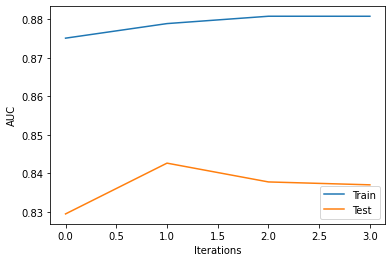

In [33]:
plt.plot(np.arange(len(model.evals_result_['validation_0']['auc'])),\
        model.evals_result_['validation_0']['auc'])
plt.plot(np.arange(len(model.evals_result_['validation_1']['auc'])),\
        model.evals_result_['validation_1']['auc'])

plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.legend(labels=['Train','Test'])


plt.show()



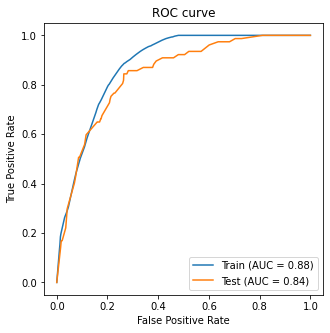

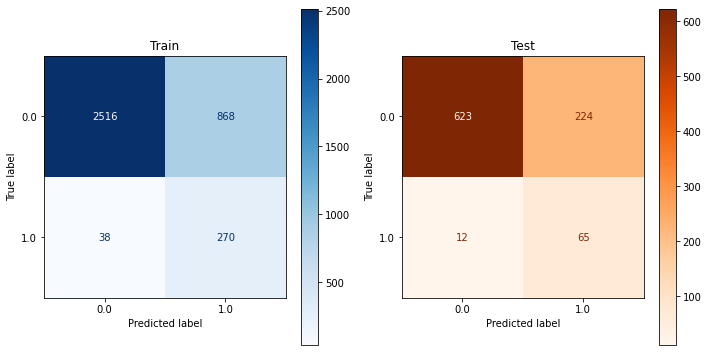

Train Precision 0.237
Train Recall    0.877

Test Precision  0.225
Test Recall     0.844


In [34]:
Model_Eval(model,X_train,X_test,y_train,y_test)

Weighting the positive cases made a big difference.  The AUC and recall are quite good, but the precision has gone down to ~22%.  Now I will use cross validation to test the accuracy and how well this model generalizes. 

In [35]:
from sklearn.model_selection import StratifiedKFold,cross_validate
kfold = StratifiedKFold(n_splits = 5, random_state=random_seed)

fit_params = {'eval_metric':'auc'}

model = xgboost.XGBClassifier(scale_pos_weight = w8,\
                              random_state=random_seed)

scores = cross_validate(model, X_train, y_train, cv=kfold,\
                        fit_params=fit_params, \
                        scoring = ['recall','roc_auc','precision','roc_auc_ovo_weighted'],\
                       return_train_score=True)

C:\Users\blain\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when co

In [36]:
pd.DataFrame(scores)

,fit_time,score_time,test_recall,train_recall,test_roc_auc,train_roc_auc,test_precision,train_precision,test_roc_auc_ovo_weighted,train_roc_auc_ovo_weighted
0,0.187659,0.009992,0.838710,0.886179,0.854434,0.887141,0.229075,0.233906,0.854434,0.887141
1,0.186040,0.011032,0.935484,0.878049,0.879449,0.880338,0.243697,0.227129,0.879449,0.880338
2,0.180500,0.010031,0.754098,0.898785,0.804247,0.893065,0.186992,0.241304,0.804247,0.893065
3,0.188197,0.011036,0.704918,0.919028,0.802528,0.896906,0.191111,0.240466,0.802528,0.896906
4,0.180896,0.011057,0.806452,0.890244,0.850723,0.886248,0.222222,0.238562,0.850723,0.886248


In [37]:
pd.DataFrame(scores).mean()

fit_time                      0.184658
score_time                    0.010630
test_recall                   0.807932
train_recall                  0.894457
test_roc_auc                  0.838276
train_roc_auc                 0.888740
test_precision                0.214620
train_precision               0.236273
test_roc_auc_ovo_weighted     0.838276
train_roc_auc_ovo_weighted    0.888740
dtype: float64

The xgboost model performs well when run through cross validation.  The ROC AUC and the recall are above 80% on average and there doesn't appear to be any overfitting.  Finally I will attempt to tune the learning rate.  

In [38]:

params = {'learning_rate':[.001,.01,.1]}

model = xgboost.XGBClassifier(scale_positive_weight = w8,\
                             random_state=random_seed)

xgb_grid = GridSearchCV(model,param_grid=params,cv=5,scoring=['recall','roc_auc'],\
                       refit = 'roc_auc',return_train_score=True)
xgb_grid.fit(X_train,y_train)

print()
print('Best params:',xgb_grid.best_params_)



C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:39] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:39] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:40] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:40] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.

C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:40] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:40] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.

C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:41] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:41] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:41] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:41] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:41] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.

C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:42] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:42] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:42] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:42] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:43] WARNING: ..\src\learner.cc:541: 
Parameters: { scale_positive_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.

In [39]:
pd.DataFrame(xgb_grid.cv_results_)[['params','mean_test_recall','mean_test_roc_auc']]

,params,mean_test_recall,mean_test_roc_auc
0,{'learning_rate': 0.001},0.058329,0.797231
1,{'learning_rate': 0.01},0.035537,0.826142
2,{'learning_rate': 0.1},0.100529,0.839869


It looks like the "scale positive weight" parameter that improved recall was not used in the fitting of the model for grid search and class validation.  As a result the recall scores are very low, while the AUC scores are about where I expected.  I will train the model with a learning rate of 0.1 and weight the positive cases as I did before. 

In [40]:
eval_set=[(X_train,y_train),(X_test,y_test)]
eval_metric = ['error','auc']


model = xgboost.XGBClassifier(learning_rate=0.1, scale_pos_weight = w8,\
                              random_state=random_seed)

model.fit(X_train,y_train,eval_metric=eval_metric, \
          early_stopping_rounds=2,eval_set=eval_set,verbose=True)
### added ea

[0]	validation_0-error:0.26273	validation_0-auc:0.87509	validation_1-error:0.27165	validation_1-auc:0.82951
[1]	validation_0-error:0.25515	validation_0-auc:0.87661	validation_1-error:0.26515	validation_1-auc:0.83642
[2]	validation_0-error:0.25027	validation_0-auc:0.87760	validation_1-error:0.26082	validation_1-auc:0.83264
[3]	validation_0-error:0.25027	validation_0-auc:0.87851	validation_1-error:0.26082	validation_1-auc:0.83289


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=10.987012987012987, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

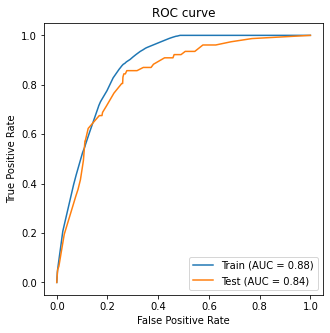

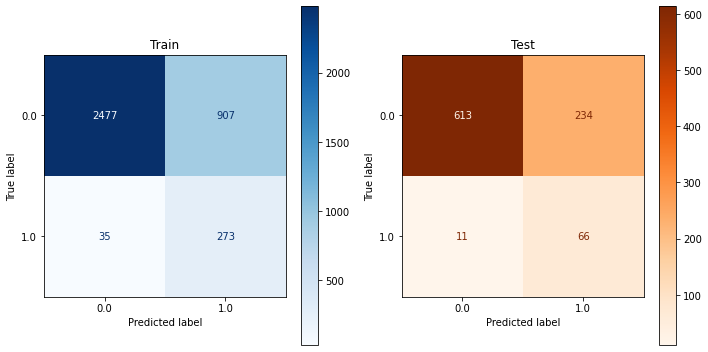

Train Precision 0.231
Train Recall    0.886

Test Precision  0.220
Test Recall     0.857


In [41]:
Model_Eval(model,X_train,X_test,y_train,y_test)

This looks pretty good.  I will add it to my set of all models now. 

In [42]:
scores_df = agg_score_df(scores_df,model,'XG Boost tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
1,RandomForest tuned,0.8791620613429124,0.8330241187384044,0.24442379182156135,0.8538961038961039,0.22262773722627738,0.7922077922077922
2,Gradient Boost default,0.8775741840901417,0.8401846087796501,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039
3,Gradient Boost tuned,0.8255157962604772,0.7522731105966054,0.5512820512820513,0.1396103896103896,0.45,0.11688311688311688
4,XG Boost default,0.8843363344693133,0.8361673745380948,0.6,0.1266233766233766,0.47368421052631576,0.11688311688311688
5,XG Boost tuned,0.8766080255441958,0.8364203682975819,0.23135593220338982,0.8863636363636364,0.22,0.8571428571428571


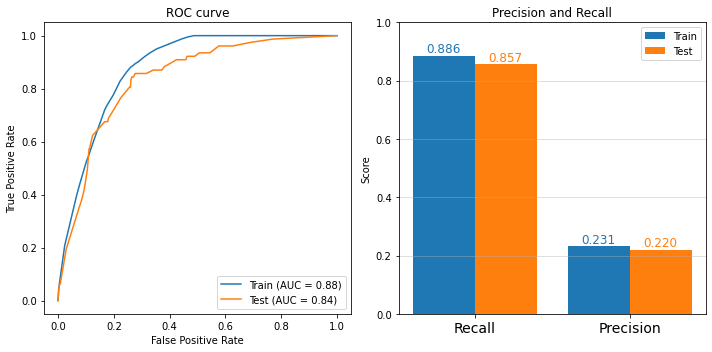

In [43]:
fig,ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
plot_roc_curve(model,X_train,y_train,ax=ax[0],name='Train')
plot_roc_curve(model,X_test,y_test,ax=ax[0],name='Test')
ax[0].set_title('ROC curve')


#plt.show()
trainnn = [recall_score(y_train,model.predict(X_train)),\
           precision_score(y_train,model.predict(X_train))]
testtt = [recall_score(y_test,model.predict(X_test)),\
          precision_score(y_test,model.predict(X_test))]

ind = np.arange(2)
width = .4


ax[1].bar(ind-width/2,trainnn,width,label='Train')
ax[1].bar(ind+width/2,testtt,width,label='Test')


ax[1].set_title('Precision and Recall')
ax[1].set_xticks(ind)
ax[1].set_xticklabels(['Recall','Precision'],fontsize=14)
ax[1].set_ylabel('Score')
ax[1].set_ylim((0,1))

ax[1].legend(loc='upper right')
ax[1].grid(axis='y',alpha=.5)

for bar in ax[1].patches:
  # The text annotation for each bar should be its height.
  bar_value = bar.get_height()
  # Format the text with commas to separate thousands. You can do
  # any type of formatting here though.
  text = '{:.3f}'.format(bar_value)
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax[1].text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)


plt.show()



# Support Vector Machine

In [44]:
from sklearn.svm import SVC

In [45]:
### try default Support vector classifier

params={'C':[1],'class_weight':['balanced']}
### without balanced class weights the model only predicts negatives

svc = SVC(random_state=random_seed,probability=True)

grid_svc = GridSearchCV(svc,param_grid=params,cv=5,n_jobs=-1,\
                       scoring = make_scorer(roc_auc_score))

grid_svc.fit(X_train,y_train)

print('Best Params: ',grid_svc.best_params_)
print('Best Score; ',grid_svc.best_score_)

Best Params:  {'C': 1, 'class_weight': 'balanced'}
Best Score;  0.7539039869259679


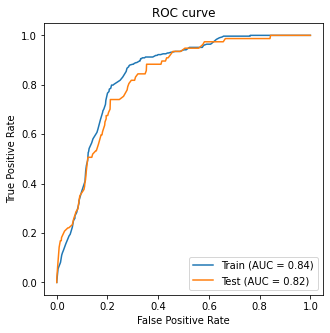

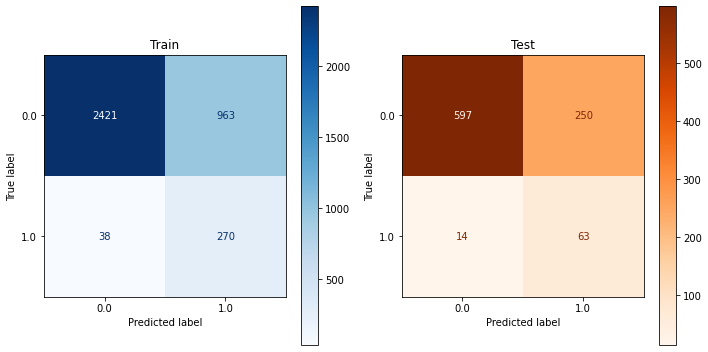

Train Precision 0.219
Train Recall    0.877

Test Precision  0.201
Test Recall     0.818


In [46]:
Model_Eval(grid_svc,X_train,X_test,y_train,y_test)

In [47]:
scores_df = agg_score_df(scores_df,grid_svc,'SVC default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
2,Gradient Boost default,0.8775741840901417,0.8401846087796501,0.6382978723404256,0.09740259740259741,0.47058823529411764,0.1038961038961039
3,Gradient Boost tuned,0.8255157962604772,0.7522731105966054,0.5512820512820513,0.1396103896103896,0.45,0.11688311688311688
4,XG Boost default,0.8843363344693133,0.8361673745380948,0.6,0.1266233766233766,0.47368421052631576,0.11688311688311688
5,XG Boost tuned,0.8766080255441958,0.8364203682975819,0.23135593220338982,0.8863636363636364,0.22,0.8571428571428571
6,SVC default,0.8384769043013723,0.8210490807893406,0.21897810218978103,0.8766233766233766,0.2012779552715655,0.8181818181818182


Wow that looks pretty great.  The AUC values are above .8 with only a small difference between them.  The recall's are very high, and the model has low bias. Now I will try to improve the result with hyper-parameter tuning. 

In [48]:
### try tuning the SVC

params={'C':[1,1.5,2,4], 'kernel':['rbf','linear'],\
        'gamma':['scale','auto'], 'class_weight':['balanced']}

svc = SVC(random_state=random_seed,probability=True)

grid_svc = GridSearchCV(svc,param_grid=params,cv=5,n_jobs=-1,\
                        scoring=make_scorer(roc_auc_score))

grid_svc.fit(X_train,y_train)

print('Best Params: ',grid_svc.best_params_)
print('Best Score; ',grid_svc.best_score_)

Best Params:  {'C': 4, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best Score;  0.7680482388057593


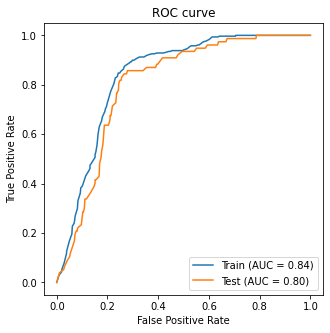

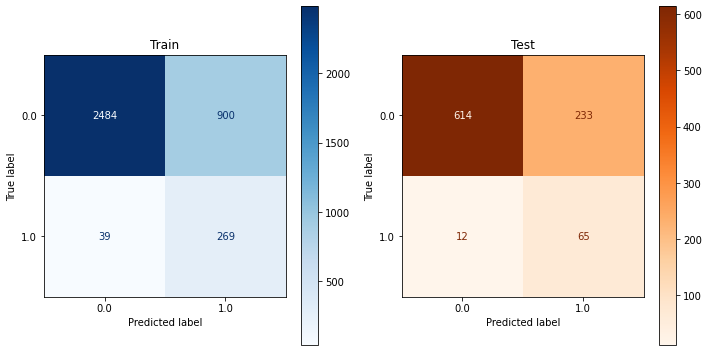

Train Precision 0.230
Train Recall    0.873

Test Precision  0.218
Test Recall     0.844


In [49]:
Model_Eval(grid_svc,X_train,X_test,y_train,y_test)

In [50]:
scores_df = agg_score_df(scores_df,grid_svc,'SVC tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
3,Gradient Boost tuned,0.8255157962604772,0.7522731105966054,0.5512820512820513,0.1396103896103896,0.45,0.11688311688311688
4,XG Boost default,0.8843363344693133,0.8361673745380948,0.6,0.1266233766233766,0.47368421052631576,0.11688311688311688
5,XG Boost tuned,0.8766080255441958,0.8364203682975819,0.23135593220338982,0.8863636363636364,0.22,0.8571428571428571
6,SVC default,0.8384769043013723,0.8210490807893406,0.21897810218978103,0.8766233766233766,0.2012779552715655,0.8181818181818182
7,SVC tuned,0.8368794326241136,0.8020208834848739,0.23011120615911035,0.8733766233766234,0.2181208053691275,0.8441558441558441


The model Roc plots are very similar to the default, but the grid search found $C=4$ to produce a better result. The SVC model appears to generalize well to the testing data to the training data and the AUC is high with much higher recall.

## Logistic Regression

Try tuning a logistic regression model again after some practice working with other models.  

In [51]:
from sklearn.linear_model import LogisticRegression


logr = LogisticRegression(random_state=random_seed,n_jobs=-1)

params = {'C':[.01,.1,.5,1,1.5,5,10], 'class_weight':[None,'balanced'],\
         'penalty':['l1','l2'], 'tol':[1E-5,1E-4,1E-3],'max_iter':[200]}

grid_logr = GridSearchCV(logr,param_grid=params,cv=5,n_jobs=-1,\
                         scoring=make_scorer(roc_auc_score))

grid_logr.fit(X_train,y_train)

print('Train AUC:',roc_auc_score(y_train,grid_logr.predict_proba(X_train)[:,1]))
print('Test AUC:',roc_auc_score(y_test,grid_logr.predict_proba(X_test)[:,1]))


Train AUC: 0.7954363160480182
Test AUC: 0.775801530228921


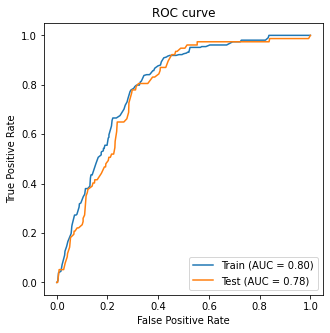

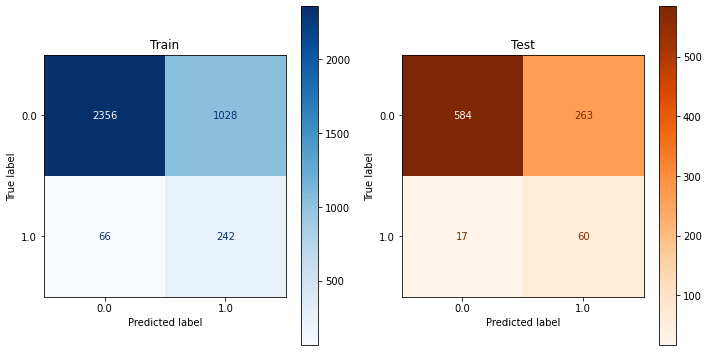

Train Precision 0.191
Train Recall    0.786

Test Precision  0.186
Test Recall     0.779


In [52]:
Model_Eval(grid_logr,X_train,X_test,y_train,y_test)

The tuned Logistic Regression Model looks pretty OK.  The ROC curves are not very steep and the AUC is a little lower than some other models.    It is clearly not overfit to the training data and has pretty good recall.

In [53]:
scores_df = agg_score_df(scores_df,grid_logr,'LogReg tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
4,XG Boost default,0.8843363344693133,0.8361673745380948,0.6,0.1266233766233766,0.47368421052631576,0.11688311688311688
5,XG Boost tuned,0.8766080255441958,0.8364203682975819,0.23135593220338982,0.8863636363636364,0.22,0.8571428571428571
6,SVC default,0.8384769043013723,0.8210490807893406,0.21897810218978103,0.8766233766233766,0.2012779552715655,0.8181818181818182
7,SVC tuned,0.8368794326241136,0.8020208834848739,0.23011120615911035,0.8733766233766234,0.2181208053691275,0.8441558441558441
8,LogReg tuned,0.7954363160480182,0.775801530228921,0.19055118110236222,0.7857142857142857,0.18575851393188855,0.7792207792207793


# Evaluate performance of all models and the choose best model

In [54]:
### Sort and change column types to numeric
scores_df = scores_df.drop_duplicates()


for c in scores_df.columns:
    if c =='Model': continue
    scores_df[c] = pd.to_numeric(scores_df[c])
scores_df = scores_df.sort_values(by='Test_AUC',ascending=False)

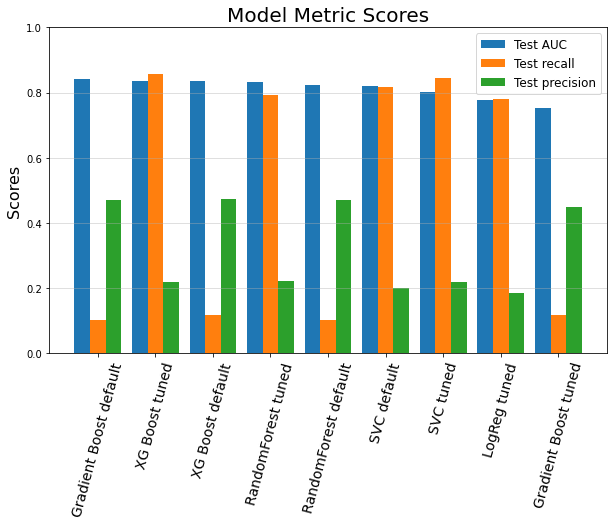

In [55]:
### Bar plot of Test AUC and Test Recall

ind = np.arange(scores_df.shape[0])
width = .27

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(ind-width,scores_df.Test_AUC,width,label='Test AUC')
ax.bar(ind,scores_df.Test_recal,width,label='Test recall')
ax.bar(ind+width,scores_df.Test_prec,width,label='Test precision')

ax.set_ylabel('Scores',fontsize=16)

ax.set_ylim(0,1)

ax.set_xticks(ind)
ax.set_xticklabels(scores_df.Model,rotation=75,fontsize=14)

ax.set_title('Model Metric Scores',fontsize=20)
ax.legend(fontsize=12)
ax.grid(axis='y',alpha=.5)

plt.show()



The plot above shows the performance of all of the models on the testing set, ordered by test AUC.  After looking at the above plot I will select the tuned XG boost model.  This model offers a high AUC performance with an almost equally high recall.  The Random forest and the SVC models also performed well on this data set.  
___
I will use the `shap` library to inspect the XGB classifier

In [56]:
feats = list(pd.read_csv('X_train.csv',index_col=0).columns)

[0]	validation_0-auc:0.87509	validation_1-auc:0.82951
[1]	validation_0-auc:0.87661	validation_1-auc:0.83642
[2]	validation_0-auc:0.87760	validation_1-auc:0.83264
[3]	validation_0-auc:0.87851	validation_1-auc:0.83289


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


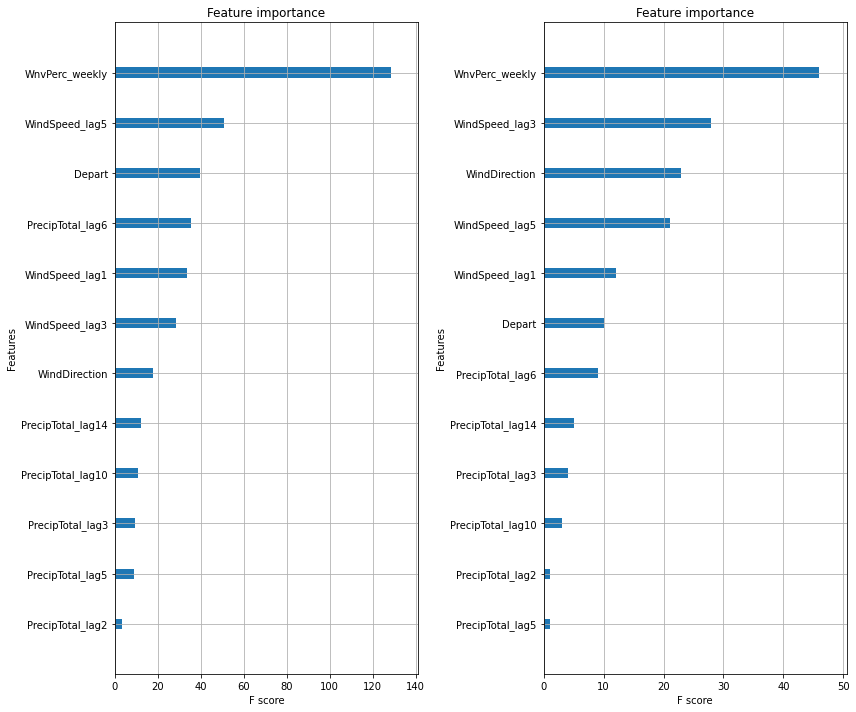

In [57]:
### Best model, XGBoost

model = xgboost.XGBClassifier(learning_rate=0.1, scale_pos_weight = w8)

model.fit(X_train,y_train,eval_metric='auc', \
          early_stopping_rounds=2,eval_set=eval_set,verbose=True)

model.get_booster().feature_names = feats

fig,ax = plt.subplots(1,2,figsize=(12,10),tight_layout=True)
xgboost.plot_importance(model.get_booster(),ax=ax[0],importance_type='gain',show_values=False)
xgboost.plot_importance(model.get_booster(),ax=ax[1],importance_type='weight',show_values=False)
plt.show()

In [58]:
import shap

C:\Users\blain\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\blain\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\blain\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\blain\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [59]:
explainer = shap.TreeExplainer(model)
shap_vals = np.array(explainer.shap_values(X_train))
print(shap_vals.shape)

(3692, 12)


In [60]:
X_train = pd.read_csv('X_train.csv',index_col=0)

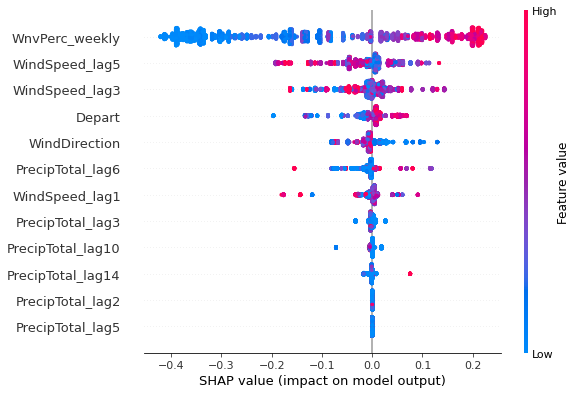

In [61]:
shap.summary_plot(shap_vals,X_train)

It looks like the model output is predominantly influenced by the historical percent of WNV cases by week of the year. A high value has a positive impact on the probability for a positive case.  

Wind speed during the previous days are of secondary importance.  High values of wind speed translates to a lower probability of a positive case.   

Depart (temperature depart from normal) also has a significant impact on the model.  A high Depart value has a positive impact on the probability of positive case.  

The lagged precipitation features don't have an obvious effect on the model from this plot, except for the 6 day lag.  That feature clearly shows an increase in case probability with higher values.  

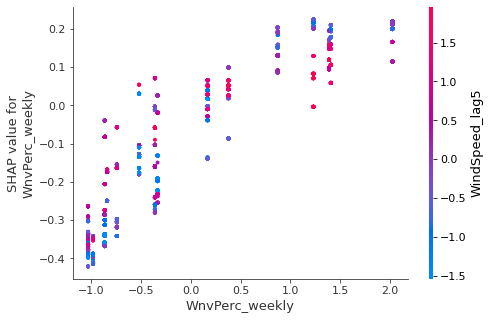

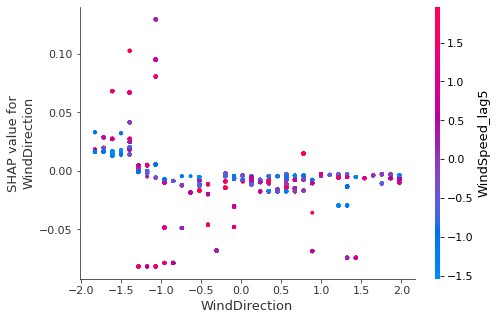

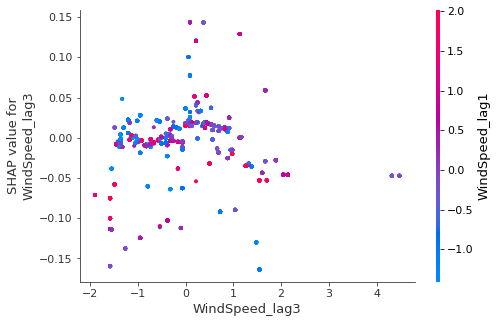

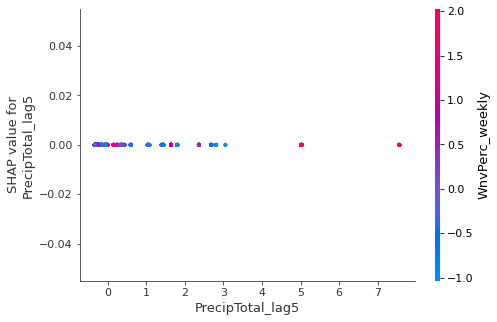

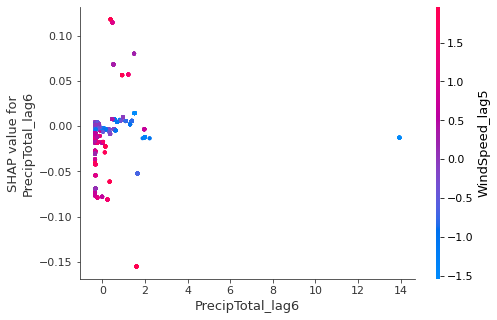

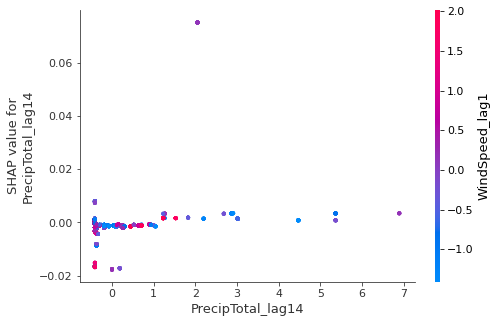

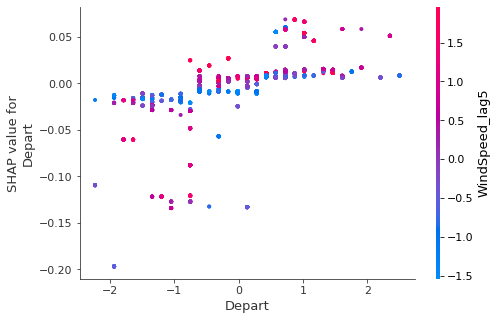

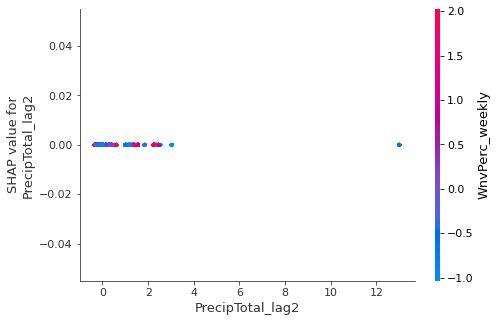

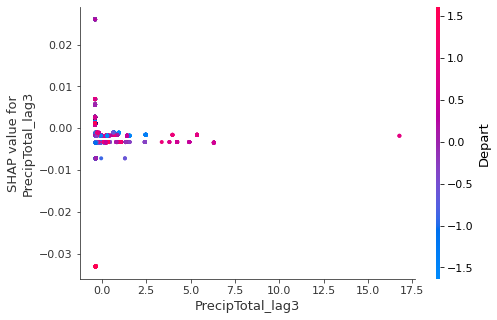

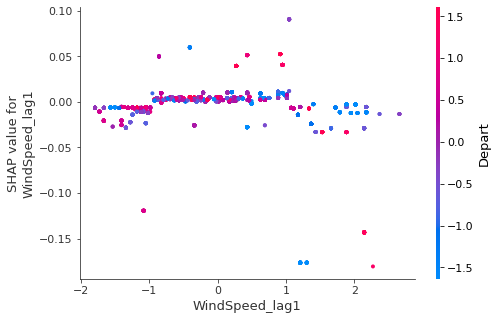

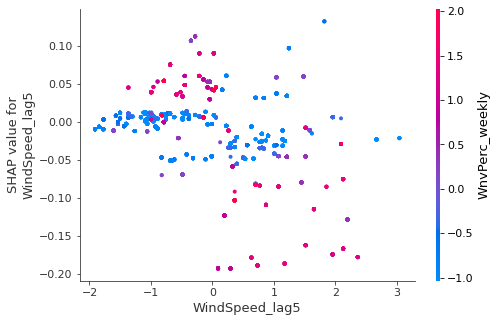

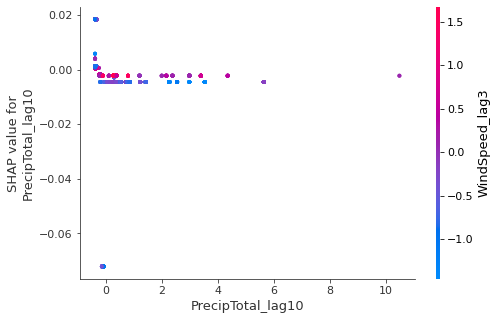

In [62]:
for f in list(X_train.columns):
    shap.dependence_plot(f,shap_vals,X_train)
    plt.show()

A closer look at the individual features confirms my observations above. It also shows that some of the features in my model don't seem to have a clear impact at all on the model.  Perhaps they are unncessary, or I need to go back and include others instead.  

Now I will concatenate the dataset and train the Random Forest Model on all of the data so it is ready for deployment.  

In [63]:
### Concatenate the train and test sets into one large training set 
X = pd.concat([pd.DataFrame(X_train),pd.DataFrame(X_test)]).to_numpy()
y = pd.concat([pd.Series(y_train),pd.Series(y_test)]).to_numpy()

In [64]:
### Create xgboost model trained on all of the available data
### ready for deployment
model = xgboost.XGBClassifier(learning_rate=0.1, scale_pos_weight = w8)

model.fit(X,y,eval_metric='auc')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=10.987012987012987, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Now I have a XGBoost classifier tuned and tested that has now been trained on all of the available data and is ready for deployment.  
___
Now I will 'pickle' the model and save it. 

In [65]:
raise('STOP')

TypeError: exceptions must derive from BaseException

In [66]:
import pickle
with open('XGBoost_final_classifier.pkl','wb') as fid:
    pickle.dump(model,fid)

# Fin